#RAG


In [64]:
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

## 1. Document/Text Processing and Embedding Creation


### Import PDF Document


In [65]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "Human-Nutrition.pdf"


In [66]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    #Performs minor formatting on text.
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 42,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

1208it [00:01, 720.53it/s]


[{'page_number': -42,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -41,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [67]:
import random

random.sample(pages_and_texts, k=1)

[{'page_number': 754,
  'page_char_count': 1302,
  'page_word_count': 200,
  'page_sentence_count_raw': 17,
  'page_token_count': 325.5,
  'text': 'whole-grain foods, fish, poultry, and nuts are emphasized while red  meats, sweets, and sugar-containing beverages are mostly avoided.  Results from a follow-up study published in the December 2009  issue of the Journal of Human Hypertension suggest the low- sodium DASH diet reduces oxidative stress, which may have  contributed to the improved blood vessel function observed in salt- sensitive people (between 10 to 20 percent of the population)6.  Diets high in fruits and vegetables. An analysis of The Nurses’  Health Study and the Health Professionals’ Follow-up Study  reported that for every increased serving of fruits or vegetables  per day, especially green leafy vegetables and vitamin C-rich fruits,  there was a 4 percent lower risk for heart disease7.  6.\xa0Al-Solaiman Y, et al. (2008). Low-Sodium DASH Reduces  Oxidative Stress and Im

### Some stats on the text


In [68]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-42,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-41,0,1,1,0.00,
2,-40,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-39,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-38,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [69]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,561.50,1148.59,198.89,9.97,287.15
std,348.86,560.44,95.75,6.19,140.11
min,-42.00,0.00,1.00,1.00,0.00
25%,259.75,762.75,134.00,4.00,190.69
50%,561.50,1232.50,215.00,10.00,308.12
75%,863.25,1605.25,271.25,14.00,401.31
max,1165.00,2308.00,429.00,32.00,577.00


### Further text processing (splitting pages into sentences)



In [70]:
from spacy.lang.en import English

nlp = English()
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [71]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

100%|██████████| 1208/1208 [00:01<00:00, 814.25it/s]


In [72]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 263,
  'page_char_count': 1864,
  'page_word_count': 313,
  'page_sentence_count_raw': 12,
  'page_token_count': 466.0,
  'text': '• Focus on calories in certain food categories such as beverages  and confections, and encourage consumption of positive  nutrients and foods such as cereals and low-fat or fat-free  dairy products.  The Most Notorious Sugar  Before high-fructose corn syrup (HFCS) was marketed as the best  food and beverage sweetener, sucrose (table sugar) was the  number-one sweetener in America. (Recall that sucrose, or table  sugar, is a disaccharide consisting of one glucose unit and one  fructose unit.) HFCS also contains the simple sugars fructose and  glucose, but with fructose at a slightly higher concentration. In  the production of HFCS, corn starch is broken down to glucose,  and some of the glucose is then converted to fructose. Fructose  is sweeter than glucose; hence many food manufacturers choose  to sweeten foods with HFCS. HFCS is used as a

In [73]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,561.50,1148.59,198.89,9.97,287.15,10.32
std,348.86,560.44,95.75,6.19,140.11,6.30
min,-42.00,0.00,1.00,1.00,0.00,0.00
25%,259.75,762.75,134.00,4.00,190.69,5.00
50%,561.50,1232.50,215.00,10.00,308.12,10.00
75%,863.25,1605.25,271.25,14.00,401.31,15.00
max,1165.00,2308.00,429.00,32.00,577.00,28.00


### Chunking sentences together


In [74]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:

    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

100%|██████████| 1208/1208 [00:00<00:00, 772012.68it/s]


In [75]:
random.sample(pages_and_texts, k=1)

[{'page_number': 977,
  'page_char_count': 1812,
  'page_word_count': 290,
  'page_sentence_count_raw': 21,
  'page_token_count': 453.0,
  'text': '• People with health issues that affect their ability to eat  • Vegetarians, vegans, and others avoiding certain food groups  However, before you begin using dietary supplementation, consider  that the word supplement denotes something being added.  Vitamins, minerals, and other assorted remedies should be  considered as extras. They are add-ons—not replacements—for a  healthy diet. As food naturally contains nutrients in its proper  package, remember that food should always be your primary source  of nutrients. When considering taking supplements, it is important  to recognize possible drawbacks that are specific to each kind:2  • Micronutrient Supplements. Some vitamins and minerals are  toxic at high doses. Therefore, it is vital to adhere to the  Tolerable Upper Intake Levels\xa0 (UL) so as not to consume too  much of any vitamin. For e

In [76]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,561.50,1148.59,198.89,9.97,287.15,10.32,1.53
std,348.86,560.44,95.75,6.19,140.11,6.30,0.64
min,-42.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,259.75,762.75,134.00,4.00,190.69,5.00,1.00
50%,561.50,1232.50,215.00,10.00,308.12,10.00,1.00
75%,863.25,1605.25,271.25,14.00,401.31,15.00,2.00
max,1165.00,2308.00,429.00,32.00,577.00,28.00,3.00


### Splitting each chunk into its own item



In [77]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

100%|██████████| 1208/1208 [00:00<00:00, 40963.05it/s]


1843

In [78]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 1078,
  'sentence_chunk': 'The carbon dioxide gas bubbles infiltrate the stretchy gluten, giving bread its porosity and tenderness. For those who are sensitive to gluten, it is good to know that corn, millet, buckwheat, and oats do not contain the proteins that make gluten. However, some people who have celiac disease also may have a response to products containing oats. This is most likely the result of cross-contamination of grains during harvest, storage, packaging, and processing. Celiac disease is most common in people of European descent and is rare in people of African American, Japanese, and Chinese descent. It is much more prevalent in women and in people with Type 1 diabetes, autoimmune thyroid disease, and Down and Turner syndromes. Symptoms can range from mild to severe and can include pale, fatty, loose stools, gastrointestinal upset, abdominal pain, weight loss and, in children, a failure to grow and thrive. The symptoms can appear in infancy or much late

In [79]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,582.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-42.00,12.00,3.00,3.00
25%,279.50,315.00,45.00,78.75
50%,585.00,746.00,114.00,186.50
75%,889.00,1118.50,173.00,279.62
max,1165.00,1831.00,297.00,457.75


In [80]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 21.75 | Text: Advanced nutrition and human metabolism. Boston, MA: Cengage Learning. Molybdenum | 693
Chunk token count: 23.75 | Text: view it online here: http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=153   194 | Chloride
Chunk token count: 5.5 | Text: 1050 | Comparing Diets
Chunk token count: 10.75 | Text: Accessed December 10, 2017. 880 | Childhood
Chunk token count: 5.25 | Text: 754 | MyPlate Planner


In [81]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -40,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

### Embedding our text chunks


In [82]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu")

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/Users/ananyanagpal/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07983255e-02  3.03164609e-02 -2.01217886e-02  6.86484426e-02
 -2.55256090e-02 -8.47688876e-03 -2.07205681e-04 -6.32378235e-02
  2.81606652e-02 -3.33354138e-02  3.02633736e-02  5.30721806e-02
 -5.03527038e-02  2.62288675e-02  3.33313979e-02 -4.51577231e-02
  3.63045260e-02 -1.37118902e-03 -1.20170861e-02  1.14947343e-02
  5.04510589e-02  4.70857024e-02  2.11913586e-02  5.14606535e-02
 -2.03747060e-02 -3.58889624e-02 -6.67802757e-04 -2.94394176e-02
  4.95859012e-02 -1.05640041e-02 -1.52014140e-02 -1.31752912e-03
  4.48197126e-02  1.56023549e-02  8.60379487e-07 -1.21395756e-03
 -2.37978809e-02 -9.09407332e-04  7.34489923e-03 -2.53938115e-03
  5.23370355e-02 -4.68043573e-02  1.66214835e-02  4.71579209e-02
 -4.15599197e-02  9.01949359e-04  3.60278487e-02  3.42214443e-02
  9.68227386e-02  5.94829433e-02 -1.64984595e-02 -3.51249278e-02
  5.92519669e-03 -7.07921281e-04 -2.4103

### Save embeddings to file


In [83]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [84]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-40,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
1,-39,Human Nutrition: 2020 Edition by University of...,210,30,52.50
2,-38,Contents Preface University of Hawai‘i at Māno...,766,114,191.50
3,-37,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25
4,-36,The Cardiovascular System University of Hawai‘...,998,152,249.50


## 2. RAG - Search and Answer

### Similarity search

In [85]:
from sentence_transformers import SentenceTransformer, util
import torch
query = "Macronutrients"
print(f"Query: {query}")

# Embed the query to the same numerical space as the text examples
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

#  Get similarity scores with the dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

#top-k results
top_results_dot_product = torch.topk(dot_scores, k=2)
top_results_dot_product

Query: Macronutrients
Time take to get scores on 4 embeddings: 0.00010 seconds.


torch.return_types.topk(
values=tensor([0.1127, 0.0685]),
indices=tensor([1, 2]))

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([400, 768])
Time take to get scores on 400 embeddings: 0.00035 seconds.


In [87]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [88]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")

    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])

    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Macronutrients'

Results:
Score: 0.1127
Text:
Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND
HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY,
WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER
DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON
CALABRESE
Page number: -40


Score: 0.0685
Text:
Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and
Human Nutrition Program is licensed under a Creative Commons Attribution 4.0
International License, except where otherwise noted.
Page number: -39




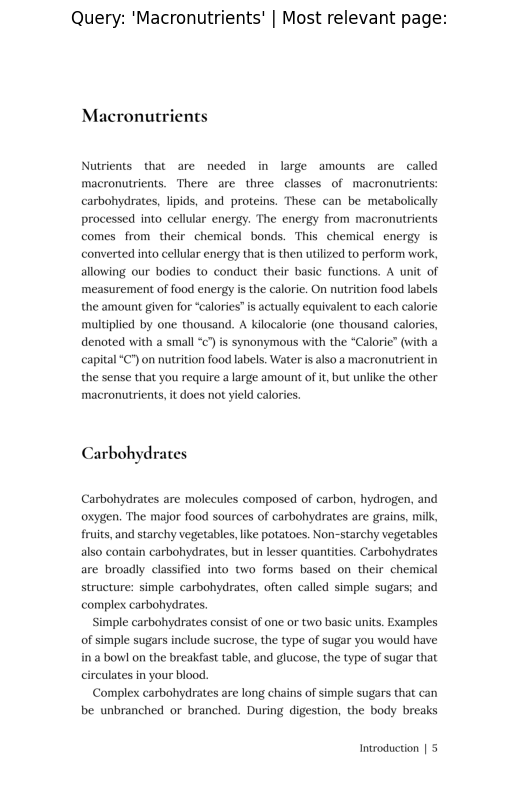

In [89]:
import fitz
import numpy as np

# Open PDF and load target page
pdf_path = "Human-Nutrition.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()